### Cross validation for linear regression
Cross validation with sklearn for linear regression on the auto-mpg dataset

***
#### Environment
`conda activate sklearn-env`

***
#### Goals
- Build a pipeline
- Use the pipeline to transform data
- Use the pipeline to predict
- Run cross validation on generated pipeline model and display default score metrics for each fold

***
#### References
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

https://scikit-learn.org/stable/modules/cross_validation.html


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

#### Dataset load from CSV located on UCI website.

http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data  
If the URL does not work the dataset can be loaded from the data folder `./data/auto-mpg.data`.

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
323,27.9,4,156.0,105.0,2800.0,14.4,80,1
222,17.0,8,260.0,110.0,4060.0,19.0,77,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
227,19.0,6,225.0,100.0,3630.0,17.7,77,1
57,24.0,4,113.0,95.0,2278.0,15.5,72,3


### Dataset split
- row base in test and train datasets
- column base in features and labels

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=random.randint(0, 1000))
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

test_labels.reset_index(drop=True, inplace=True)

#### Build the pipeline

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

numeric_features = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Origin']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

data_prep_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

#### Use the pipeline to transform data

In [5]:
data_prep_values = data_prep_pipeline.fit_transform(train_features, train_labels)

transformed_df = pd.DataFrame(data = data_prep_values)
transformed_df.head(5)

,0,1,2,3,4,5,6,7,8
0,1.557482,0.693772,-0.344272,0.564983,2.437945,0.798095,1.0,0.0,0.0
1,-0.840965,-0.906494,-0.622560,-1.242592,-0.473223,0.798095,1.0,0.0,0.0
2,0.358259,0.594990,-0.065984,0.998561,0.497166,-0.576738,1.0,0.0,0.0
3,-0.840965,-0.333560,-0.288614,-0.395854,-0.473223,1.348028,1.0,0.0,0.0
4,-0.840965,-0.916373,-0.678218,-0.780189,-0.435901,-0.576738,0.0,1.0,0.0


#### Build the full pipeline

In [6]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipeline_model = pipeline.fit(train_features, train_labels)
print(pipeline_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Cylinders', 'Displacement',
                                                   'Horsepower', 'Weight',
                                                   'Acceleration',
                                                   'Model Year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Origin'])])),
                ('regressor', LinearRegression())])


In [7]:
from sklearn import set_config

set_config(display='diagram')
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Cylinders', 'Displacement',
                                                   'Horsepower', 'Weight',
                                                   'Acceleration',
                                                   'Model Year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Origin'])])),
                ('regressor', LinearRegression())])

#### Use pipeline to predict values

In [8]:
scored_data = pipeline.predict(test_features)

#### Show predicted values

In [9]:
scored_df = pd.DataFrame(data = scored_data)

scored_df = pd.concat([scored_df, test_labels], axis=1)
scored_df.head(5)

,0,MPG
0,14.015444,15.0
1,10.397067,14.0
2,9.864148,14.0
3,13.039408,15.0
4,19.318016,18.0


### Cross Validation

In [10]:
from sklearn.model_selection import cross_val_score
folds = 10

scores = cross_val_score(pipeline,train_features, train_labels, cv=folds)
scores

array([0.688, 0.788, 0.751, 0.822, 0.852, 0.772, 0.822, 0.848, 0.827,
       0.788])

In [11]:
print("%0.2f R-squared (R2), with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.80 R-squared (R2), with a standard deviation of 0.05


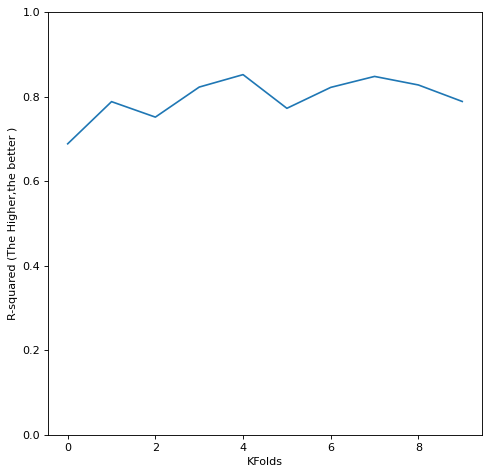

In [12]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=80)
plt.ylim(0,1)
plt.plot(range(folds), scores)
ax.set_xlabel('KFolds')
ax.set_ylabel('R-squared (The Higher,the better )')
plt.show()

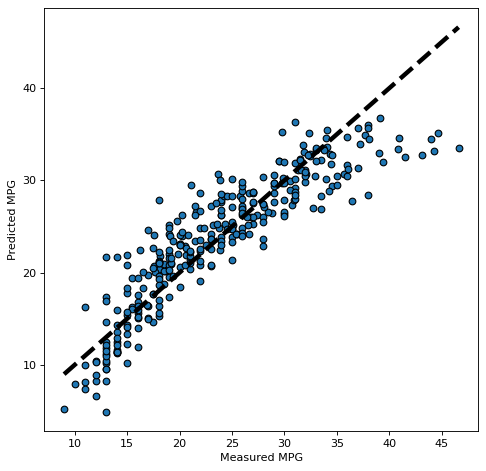

In [13]:
from sklearn.model_selection import cross_val_predict
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(pipeline, train_features, train_labels, cv=10)

fig, ax = plt.subplots(figsize=(7, 7), dpi=80)
ax.scatter(train_labels, predicted, edgecolors=(0, 0, 0))
ax.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], 'k--', lw=4)
ax.set_xlabel('Measured MPG')
ax.set_ylabel('Predicted MPG')
plt.show()